In [14]:
import pandas as pd
import requests
from tqdm import tqdm
from time import sleep
from Bio import Entrez, SeqIO
import re

# —– USER PARAMETERS —–
input_csv = r"C:\Users\poker\Downloads\CaMES_long-homologes_withoutEgtD.csv"
output_csv = "CaMES_withoutEgtD_gene_neighborhood_matrix_8neighborhood.csv"
NEIGHBORHOOD_RANGE = 8   # how many genes upstream/downstream
Entrez.email = "phitro@bu.edu"


# Helper functions

In [2]:
def get_uniprot_mappings(uniprot_id):
    """Return RefSeq protein, RefSeq nucleotide, EMBL nucleotide, EMBL protein for a UniProt ID."""
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
    r = requests.get(url, timeout=10)
    if r.status_code != 200:
        return None, None, None, None
    data = r.json()
    refseq_prot = refseq_nt = embl_nt = embl_prot = None
    for dbref in data.get('uniProtKBCrossReferences', []):
        if dbref['database'] == "RefSeq":
            refseq_prot = dbref.get('id') or refseq_prot
            for prop in dbref.get('properties', []):
                if prop['key'] == 'NucleotideSequenceId':
                    refseq_nt = prop['value']
        elif dbref['database'] == "EMBL":
            embl_nt = dbref.get('id') or embl_nt
            for prop in dbref.get('properties', []):
                if prop['key'].lower() in ['protein sequence id', 'proteinid', 'protein_id']:
                    embl_prot = prop['value']
    return refseq_prot, refseq_nt, embl_nt, embl_prot

def extract_contig_block(gb_text):
    """Pull out the CONTIG block from a GenBank flat‐file."""
    lines = gb_text.splitlines()
    out = []
    in_block = False
    for L in lines:
        if L.lstrip().startswith("CONTIG"):
            in_block = True
            out.append(L.strip())
        elif in_block and (L.startswith(" ") or L.startswith("\t")):
            out.append(L.strip())
        elif in_block:
            break
    return " ".join(out)

def get_contigs_from_refseq(refseq_nt, embl_nt):
    """Given a RefSeq accession, fetch the GENBANK and parse the CONTIG line(s)."""
    try:
        with Entrez.efetch(db='nuccore', id=refseq_nt, rettype='gb', retmode='text') as h:
            gb = h.read()
        cb = extract_contig_block(gb)
        if not cb:
            return [refseq_nt]
        # look for things like JFBT01000001.1
        cts = re.findall(r'([A-Z]{4}\d{8}\.\d+)', cb)
        return cts if cts else [embl_nt]
    except Exception as e:
        print("Error fetching contigs for", refseq_nt, "–", e)
        return [embl_nt]

def get_cds_list(nuc_acc):
    """Retrieve all CDS features for a nucleotide accession."""
    out = []
    try:
        with Entrez.efetch(db='nuccore', id=nuc_acc, rettype='gbwithparts', retmode='text') as h:
            recs = SeqIO.parse(h, "genbank")
            for rec in recs:
                for idx,feat in enumerate(rec.features):
                    if feat.type!="CDS": 
                        continue
                    g    = feat.qualifiers.get('gene',     [None])[0]
                    lt   = feat.qualifiers.get('locus_tag',[None])[0]
                    pid  = feat.qualifiers.get('protein_id',[None])[0]
                    # some EMBL cross‐refs etc.
                    dbx = feat.qualifiers.get('db_xref',[])
                    embl_p = None
                    for d in dbx:
                        if d.startswith("EMBL:"):
                            embl_p = d.split("EMBL:")[1]
                        if d.startswith("protein_id:"):
                            embl_p = d.split("protein_id:")[1]
                    start = int(feat.location.start)
                    end   = int(feat.location.end)
                    strand= feat.location.strand
                    out.append(dict(
                        gene=g,
                        locus_tag=lt,
                        protein_id=pid or embl_p,
                        start=start,
                        end=end,
                        mid=(start+end)//2,
                        strand=strand,
                        idx=idx,
                        contig=rec.id
                    ))
    except Exception as e:
        print("Error parsing", nuc_acc, "–", e)
    return out

# Main pipeline

In [15]:
df = pd.read_csv(input_csv, header=None, names=['uniprot'])
neighborhood_results = []

for uni in tqdm(df['uniprot'], desc="processing proteins"):
    # 1) map UniProt → RefSeq/EMBL
    rprot, rnt, ent_nt, ent_prot = get_uniprot_mappings(uni)
    sleep(0.2)
    nuc_acc = rnt or ent_nt
    if not nuc_acc:
        print("  no nucleotide for", uni, "– skipping")
        neighborhood_results.append({'uniprot': uni})
        continue

    # 2) get all contigs
    cts = get_contigs_from_refseq(nuc_acc, ent_nt)
    sleep(0.2)

    # 3) pull all CDS features
    all_genes = []
    for c in cts:
        gg = get_cds_list(c)
        for g in gg:
            g['contig'] = c
        all_genes.extend(gg)
        sleep(0.3)

    # 4) find our “hit” gene by matching the protein‐ID
    hit = None
    if ent_prot:
        hit = next((g for g in all_genes if g['protein_id']==ent_prot), None)

    if hit is None:
        print("  cannot find matching CDS for", uni, "– skipping")
        neighborhood_results.append({'uniprot': uni})
        continue

    # 5) collect neighbors ± NEIGHBORHOOD_RANGE
    base_idx   = hit['idx']
    base_contig= hit['contig']
    row = {'uniprot': uni}

    for g in all_genes:
        if g['contig']!=base_contig:
            continue
        d = g['idx'] - base_idx
        if abs(d) > NEIGHBORHOOD_RANGE:
            continue
        # pick a name
        name = g['gene'] or g['locus_tag'] or g['protein_id'] or f"unknown_{g['idx']}"
        row[name] = d

    neighborhood_results.append(row)

# 6) assemble into a DataFrame (sparse in effect) and write out
mat = pd.DataFrame(neighborhood_results).set_index('uniprot')
mat.to_csv(output_csv)
print("Done. Neighborhood matrix written to", output_csv)

processing proteins:  77%|███████▋  | 55/71 [02:35<00:51,  3.25s/it]

  cannot find matching CDS for A0A6L3AHQ7 – skipping


processing proteins: 100%|██████████| 71/71 [03:16<00:00,  2.76s/it]

Done. Neighborhood matrix written to CaMES_withoutEgtD_gene_neighborhood_matrix_8neighborhood.csv


# Matrix Analysis

Summary written to CaMES_withoutEgtD_gene_neighborhood_matrix_8neighborhood_summary.csv
             count  percent_present  median_distance  sd_distance
nudB             2         2.816901              1.0     7.071068
nhaA             2         2.816901              8.0     0.000000
nifS             2         2.816901              0.0     0.000000
aspS             2         2.816901              1.0     4.242641
DCP03_19800      1         1.408451             -4.0          NaN
DCP03_19805      1         1.408451             -2.0          NaN
DCP03_19810      1         1.408451              0.0          NaN
DCP03_19815      1         1.408451              2.0          NaN
DCP03_19820      1         1.408451              4.0          NaN
A2603_16865      1         1.408451             -6.0          NaN


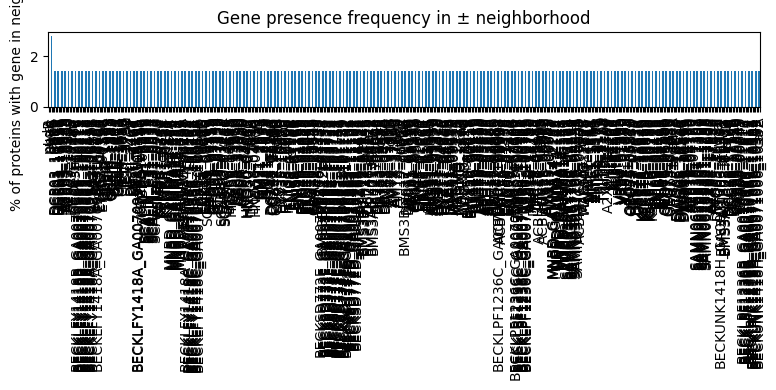

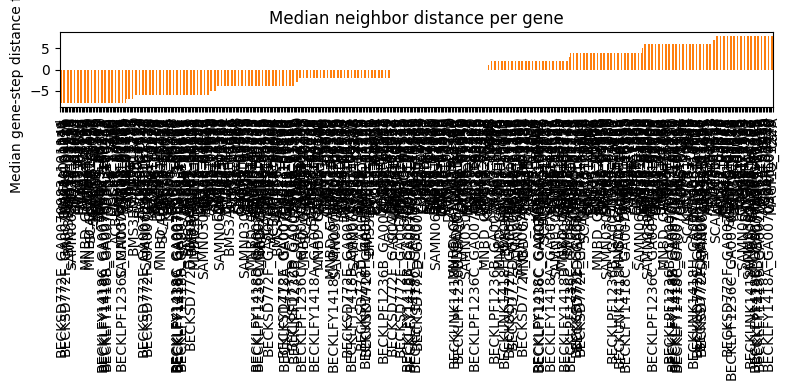

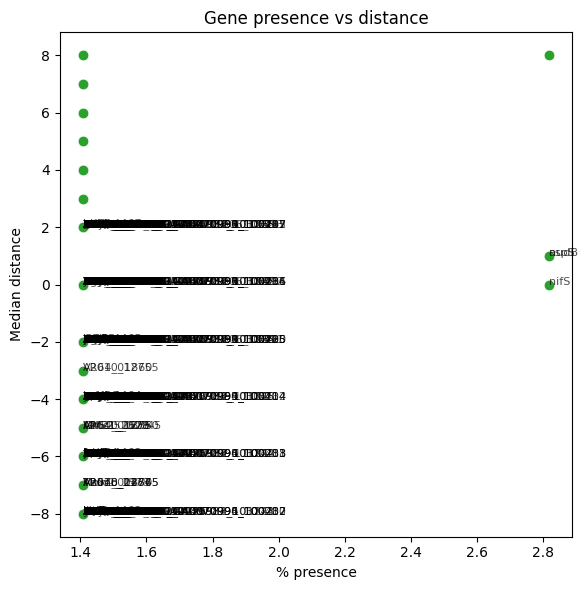

c:\Users\poker\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\poker\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


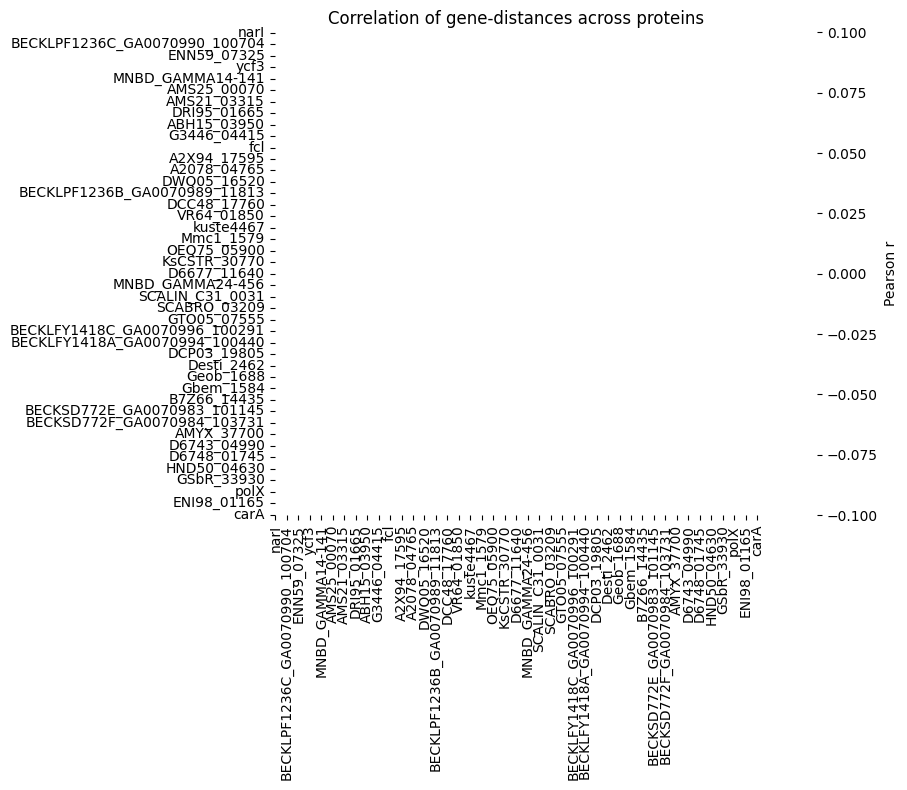

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load the matrix
in_csv  = "CaMES_withoutEgtD_gene_neighborhood_matrix_8neighborhood.csv"   # your file
summary_csv = "CaMES_withoutEgtD_gene_neighborhood_matrix_8neighborhood_summary.csv"
df = pd.read_csv(in_csv, index_col=0)

# 2) Build per-gene summary
n_proteins = len(df)
summary = pd.DataFrame(index=df.columns)
summary['count']           = df.notna().sum()                       # how many proteins have this gene
summary['percent_present'] = summary['count'] / n_proteins * 100    # percent
summary['median_distance'] = df.median(axis=0, skipna=True)         # median distance
summary['sd_distance'] = df.std(axis=0, skipna=True)                # std.dev distance

# Save the summary
summary.sort_values('percent_present', ascending=False) \
       .to_csv(summary_csv, float_format="%.2f")
print(f"Summary written to {summary_csv}")
print(summary.sort_values('percent_present', ascending=False).head(10))

# 3) Plot percent presence
plt.figure(figsize=(8,4))
summary['percent_present'] \
    .sort_values(ascending=False) \
    .plot(kind='bar', color='C0')
plt.ylabel("% of proteins with gene in neighborhood")
plt.title("Gene presence frequency in ± neighborhood")
plt.tight_layout()
plt.show()

# 4) Plot median distance
plt.figure(figsize=(8,4))
summary['median_distance'] \
    .sort_values(ascending=True) \
    .plot(kind='bar', color='C1')
plt.ylabel("Median gene-step distance from hit")
plt.title("Median neighbor distance per gene")
plt.tight_layout()
plt.show()

# 5) Scatter percent vs median
plt.figure(figsize=(6,6))
sns.scatterplot(
    x='percent_present', 
    y='median_distance', 
    data=summary,
    s=60, color='C2'
)
for gene, row in summary.iterrows():
    # annotate outliers (you can tune the thresholds)
    if row['percent_present'] > 50 or row['median_distance'] < 3:
        plt.text(row['percent_present'], row['median_distance'], gene,
                 fontsize=8, alpha=0.7)
plt.xlabel("% presence")
plt.ylabel("Median distance")
plt.title("Gene presence vs distance")
plt.tight_layout()
plt.show()

# 6) Correlation matrix of distances
#    (genes with very few observations will produce NaN rows; drop them if you like)
corr = df.corr(method='pearson', min_periods=5)  

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    cmap='vlag',
    center=0,
    linewidths=0.5,
    cbar_kws={'label':'Pearson r'},
    square=True
)
plt.title("Correlation of gene-distances across proteins")
plt.tight_layout()
plt.show()

# Optionally: cluster‐map for a dendrogram
# sns.clustermap(corr, cmap='vlag', center=0, figsize=(10,10), metric='correlation')

# Identify UniProt IDs with Methyltransferases besides them

In [28]:
import pandas as pd

def filter_aminotrans_by_mt_neighbor(file_path, output_csv_path):
    """
    Filters a TSV file of gene data to identify 'Aminotran_5; Molybdopterin' genes
    that have a length > 1000 AA AND have a methyltransferase gene within 2 positions
    (up or down) in the same genome.

    Args:
        file_path (str): The path to the input TSV file.

    Returns:
        list: A list of Uniprot IDs for the 'Aminotran_5; Molybdopterin' genes
              that meet all the specified criteria.
    """

    # Load the TSV file into a pandas DataFrame
    df = pd.read_csv(file_path, sep='\t')


    # Identify 'Aminotran_5; Molybdopterin' genes with >1000 AA ---
    # Define keywords for the target gene (case-insensitive search)
    target_gene_keywords = ['Aminotran_5', 'Molybdopterin']
    # Use a regex that requires BOTH keywords (using `(?=.*keyword1)(?=.*keyword2)`)
    target_pattern = '(?=.*' + ')(?=.*'.join(target_gene_keywords) + ')'
    
    df['is_target_gene'] = (
        df['Function'].str.contains(target_pattern, case=False, na=False) &
        (df['Size (nt)'] > 1000)
    )

    # Identify methyltransferase genes ---
    # Define keywords to identify methyltransferases (case-insensitive)
    methyltransferase_keywords = [
        'methyltransf',
        'methyltrans',
        'mthfr',          # MTHFR is a common methyltransferase
        'radical_sam',    # Radical SAM enzymes often include methyltransferases
        's-methyl_trans',
        'trm'             # tRNA methyltransferase
    ]
    mt_pattern = '|'.join(methyltransferase_keywords)
    df['is_methyltransferase'] = df['Function'].str.contains(mt_pattern, case=False, na=False)

    # Check for methyltransferase neighbors within 2 positions in the same genome ---
    # We need to look up to 2 positions away in both directions
    df['has_mt_neighbor'] = False # Initialize column

    # Group by genome to ensure neighbor checks are genome-specific
    for genome, group in df.groupby('Genome'):
        # Get the boolean series for methyltransferases in this specific genome
        mt_series = group['is_methyltransferase']
        
        # Check for MTs 1 or 2 positions before or after the current gene
        # Using .shift() with fillna(False) to handle boundaries
        mt_1_up = mt_series.shift(1).fillna(False)
        mt_2_up = mt_series.shift(2).fillna(False)
        mt_1_down = mt_series.shift(-1).fillna(False)
        mt_2_down = mt_series.shift(-2).fillna(False)
        
        # Combine all neighbor conditions. The target gene itself is NOT counted as its own neighbor.
        group_has_mt_neighbor = mt_1_up | mt_2_up | mt_1_down | mt_2_down
        
        # Update the 'has_mt_neighbor' column in the main DataFrame using the index
        df.loc[group.index, 'has_mt_neighbor'] = group_has_mt_neighbor

    # Filter for target genes that have a methyltransferase neighbor ---
    # A gene must be a 'target_gene' AND have a 'methyltransferase_neighbor'
    final_filtered_df = df[df['is_target_gene'] & df['has_mt_neighbor']]

    # Save the filtered genes to a CSV file ---
    final_filtered_df['ID'].to_csv(output_csv_path, index=False)
    print(f"Filtered genes saved to {output_csv_path}")

    # Extract the Uniprot IDs of these genes
    uniprot_codes_to_save = final_filtered_df['ID'].tolist()

    return uniprot_codes_to_save


In [30]:
my_file_path = "CaMES_10kBlast_10e_50eEdge_noFilter_300AST_min900AA_withoutEgtD_withoutMethyltrans_gene_graphics.tsv" 
output_csv_path = "CaMES_10kBlast_10e_50eEdge_noFilter_300AST_min900AA_withoutEgtD_withoutMethyltrans_gene_graphics-withMethyltrans.csv" 
    
uniprot_ids_meeting_criteria = filter_aminotrans_by_mt_neighbor(my_file_path, output_csv_path)

print("--- Uniprot IDs of 'Aminotran_5; Molybdopterin' genes (>1000 AA) with a methyltransferase neighbor (within 2 positions) ---")
print(len(uniprot_ids_meeting_criteria), "genes found")
print(uniprot_ids_meeting_criteria)

Filtered genes saved to CaMES_10kBlast_10e_50eEdge_noFilter_300AST_min900AA_withoutEgtD_withoutMethyltrans_gene_graphics-withMethyltrans.csv
--- Uniprot IDs of 'Aminotran_5; Molybdopterin' genes (>1000 AA) with a methyltransferase neighbor (within 2 positions) ---
0 genes found
[]
